Improving star-galaxy classification using mixture models
===============================

---

In this notebook we briefly show how extreme deconvolution (XD) can be a useful, unsupervised method for improving the way stars and galaxies are classified in astronomical imaging data.  Here is a breakdown of the key ideas:
- Astronomers measure the brightness of sources using 'star' models and 'galaxy' models, and report this in units of        magnitudes (more below).
- Using a threshold, the difference between these magnitudes determines the classification. 
- When the objects are faint, noise makes this an unreliable procedure.
- We want to create (hierarchically) a prior for these quantities, and do so by modeling the joint distribution of measurements using XD
- XD is a Gaussian Mixture Model which models the data as a GMM convolved with an objects measurement uncertainty.
- Using this prior we can estimate the posterior differences of magnitudes, producing a better classification

The Problem
======
Astronomers want to know what object in their images are, and typically this entails deciding whether something is a star or a galaxy.  

Running the code below provides a visualization of the problem.  Object brightnesses are recorded in 5 different filters u, g, r, i, and z (think blue to red filters) in units of magnitudes, and are produced by fitting 'star'-like models and 'galaxy'-like models.  The top left panel of the figure shows distribution of object brightness in the r filter.  Quite noticeable is the dramtic rise in the number of sources as objects get fainter (large mag == small brightness), until the objects are too faint to be detected.

The top right panel shows the difference of these star and galaxy magnitudes as a function of magnitude.  What is done by the Sloan Digital Sky Survey (SDSS, http://www.sdss.org/) is that (essentially) objects above the red line are called galaxies and below are called stars.  It is clear, however, that at the faint end of the plot (r >~ 21) this classification metric is breaking down.

Fortunately, there is structure in the measurements beyond what is recorded in a single filter.  The bottom two panels illustrate this, showing the difference in g and r filters versus the difference in r and i.  For objects called 'stars' (by the above method) the distribution is clearly different than that of objects called galaxies.  We want to exploit this information to produce better classification metrics.

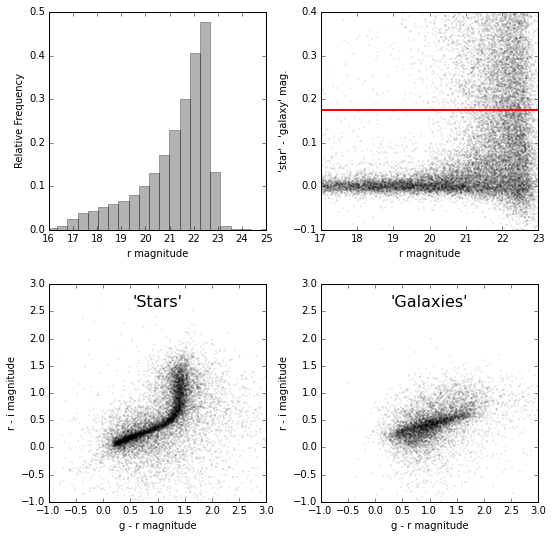

In [2]:
%matplotlib inline
import numpy as np
import pyfits as pf
import matplotlib.pyplot as pl

from xd import XDGMM, xd_model
from utils import load_xd_parms
from demo_utils import fake_data_plot, sdss_description_plot, sdss_results_plot

import warnings
warnings.filterwarnings('ignore')

# load some SDSS data and generate descriptive plot
f = pf.open('sdss_demo_train.fits')
X = f[0].data
Xcov = f[1].data
f.close()
sdss_description_plot(X)

Using Extreme Deconvolution to infer underlying distributions
=================================
Extreme Deconvolution (XD) is a method of inferring density distributions, under a model for the noise.  Conceptually this process is simple - the underlying density is a Mixture of Gaussians and the likelihood for an object is this mixture model convolved with the objects noise model.  Here is a link to the original paper: http://arxiv.org/abs/0905.2979

To illustrate, lets generate some fake data:

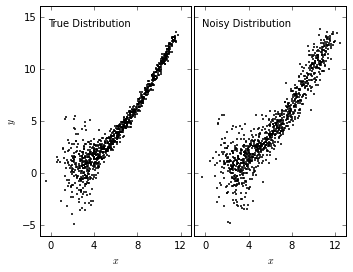

In [3]:
def generate_fake_data(N=1000, seed=1234):
    """
    Generate a set of fake data for demo purposes.
    """
    # generate the true data
    x_true = (1.4 + 2 * np.random.random(N)) ** 2
    y_true = 0.1 * x_true ** 2

    # add scatter to "true" distribution
    dx = 0.1 + 4. / x_true ** 2
    dy = 0.1 + 10. / x_true ** 2
    x_true += np.random.normal(0, dx, N)
    y_true += np.random.normal(0, dy, N)

    # add noise to get the "observed" distribution
    dx = 0.2 + 0.5 * np.random.random(N)
    dy = 0.2 + 0.5 * np.random.random(N)

    x = x_true + np.random.normal(0, dx)
    y = y_true + np.random.normal(0, dy)

    # stack the results for computation
    X = np.vstack([x, y]).T
    Xcov = np.zeros(X.shape + X.shape[-1:])
    diag = np.arange(X.shape[-1])
    Xcov[:, diag, diag] = np.vstack([dx ** 2, dy ** 2]).T
    
    # show the data
    fake_data_plot(x_true, y_true, x, y)
    
    # save it to file
    hdulist = pf.HDUList([pf.PrimaryHDU(X), pf.ImageHDU(Xcov)])
    hdulist.writeto('fake_data.fits', clobber=True)
    
    return X, Xcov, x_true, y_true
    
X, Xcov, x_true, y_true = generate_fake_data()

The above plot shows a simple distribution of the generated data (left), and the same distribution with gaussian noise added.  The goal is to recover the distribution on the left.

Lets run xd:

In [7]:
def run_xd_on_fake(N=1000, n_components=8, datafile='fake_data.fits'):
    """
    Run `Extreme Deconvolution' on generated data.
    """
    batch_size = N
    model = XDGMM(datafile, n_components, batch_size, eta=0.,
                  n_iter=50, Nthreads=2, verbose=True, savefile='xd_model.hdf5')

run_xd_on_fake()


Initalization done in 0.35 sec
Initial Log Likelihood:  -3.96583481427
Initial Valid Log Likelihood:  -3.96583481427

|  iter   |  train L   |  valid L   | weight  | itr time | tot time |  Nbad   |
-------------------------------------------------------------------------------
|    0    |  -3.9409   |  -3.9409   |    1    |   0.44   |   0.44   |    0    |
|    1    |  -3.9283   |  -3.9409   |    1    |   0.33   |   0.77   |    0    |
|    2    |  -3.9207   |  -3.9409   |    1    |   0.33   |   1.1    |    0    |
|    3    |  -3.9157   |  -3.9409   |    1    |   0.33   |   1.4    |    0    |
|    4    |  -3.9122   |  -3.9409   |    1    |   0.33   |   1.8    |    0    |
|    5    |  -3.9097   |  -3.9409   |    1    |   0.33   |   2.1    |    0    |
|    6    |  -3.9077   |  -3.9409   |    1    |   0.44   |   2.5    |    0    |
|    7    |  -3.9061   |  -3.9409   |    1    |   0.33   |   2.9    |    0    |
|    8    |  -3.9049   |  -3.9409   |    1    |   0.33   |   3.2    |    0    |
|

Lets look at the results.  The parameters are saved to the file 'xd_model.hdf5'.  Opening this we can sample from the mixture model and compare it to the generated data.  Looks pretty good!  The resampling from the XD model compares very well to the 'true' distribution we generated.

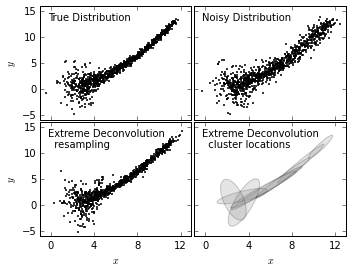

In [8]:
alphas, mus, Vs, logls, _ = load_xd_parms('xd_model.hdf5')
model = xd_model(alphas.size, X.shape)
model.alpha = alphas
model.mu = mus
model.V = Vs

samples = model.sample(size=1000)

fake_data_plot(x_true, y_true, X[:, 0], X[:, 1], samples, mus, Vs)

Running XD on SDSS photometry
================
Lets run XD on the SDSS data.  The hope here is to infer what the distribution of magnitudes should look like, in the absence of noise.

To avoid overfitting, we are going to use a validation set of data which is held out from the XD learning process (Expectation Maximization).  When the validation likelihood becomes bad, we will stop the optimization of the model.  Lets load the data, and set some indication parameters.  In particular we are going to ask the model to run with 32 mixture components.  In addition, we are going to set half of those to have mean zero and axis aligned covariances in the 'star' - 'galaxy' magnitude features.  There are five such features (on for each band), four colors (differences between filters), and the r 'star' magnitude.  For this demo we will feed the model 30k samples with a dimensionality of 10, and 5k samples for validation.  Let's run the model.

In [13]:
f = pf.open('sdss_demo_valid.fits')
Xval = f[0].data
Xvalcov = f[1].data
f.close()

K = 32
Nstar = 16
fix = [-1, -2, -3, -4, -5]
fixed_means = np.zeros((K, Xval.shape[1])) + np.inf
fixed_means[:Nstar, fix] = np.zeros(len(fix))
aligned_covs = [(i, fix) for i in range(Nstar)]

In [10]:
n_iter = 30
Ncheck = 2
batch_size = 1000

model = XDGMM('sdss_demo_train.fits', K, batch_size=batch_size, n_iter=n_iter, Nthreads=2,
              verbose=True, Xvalid=Xval, Xvalidcov=Xvalcov,
              Ncheck=Ncheck, fixed_means=fixed_means, aligned_covs=aligned_covs,
              savefile='foo.hdf5', seed=1234)



Initalization done in 4.2 sec
Initial Log Likelihood:  -2.8825993598
Initial Valid Log Likelihood:  -3.20269284094

|  iter   |  train L   |  valid L   | weight  | itr time | tot time |  Nbad   |
-------------------------------------------------------------------------------
|    0    |  -2.4861   |  -3.0912   |    1    |   5.4    |   5.4    |    0    |
|    1    |  -2.7131   |  -3.0912   | 0.93101 |   2.1    |   7.5    |    0    |
|    2    |  -2.8212   |  -2.9079   | 0.8722  |    5     |    13    |    0    |
|    3    |  -2.7622   |  -2.9079   | 0.82138 |   1.8    |    14    |    0    |

Threw out 1 outliers.
|    4    |  -3.9362   |  -2.7827   | 0.77697 |   4.7    |    19    |    0    |
|    5    |  -2.8061   |  -2.7827   | 0.73779 |   2.2    |    21    |    0    |
|    6    |  -2.0046   |  -2.7296   | 0.70293 |   5.9    |    27    |    0    |
|    7    |  -2.1187   |  -2.7296   | 0.67168 |   1.8    |    29    |    0    |
|    8    |  -2.5469   |  -2.6845   | 0.6435  |   5.1    |  

Below we are going to load the XD parameters for a model that we have previously run to completion.  Now the critical idea - use the XD model as a prior for the distribution of an objects measurement values.  This posterior is easy to calculate (though a bit slow), since the XD model is a mixture of Gaussians and we are assuming an objects measurements are Gaussian distributions as well.

In [18]:
alphas, mus, Vs, logls, _ = load_xd_parms('sdss_demo_parms.hdf5')
model = xd_model(alphas.size, Xval.shape)
model.alpha = alphas
model.mu = mus
model.V = Vs

pas, pms, pvs = model.posterior(Xval, Xvalcov)
samples = np.zeros_like(Xval)
for i in range(Xval.shape[0]):
    samples[i] = np.median(model.sample(pas[i], pms[i], pvs[i], 100), axis=0)

Posterior Calculation for datum 0
Posterior Calculation for datum 1000
Posterior Calculation for datum 2000
Posterior Calculation for datum 3000
Posterior Calculation for datum 4000


The results
======

Below is a plot that shows the results.  On the left we have the same figure as for Figure 1, but plotted for the validation data we have loaded.  In the middle panel we show the contours for the XD model. Note that for the 16 'star' components, we see they have mean zero and are axis aligned (in this projection of the features.  Interestingly, these components also demonstrate small variance in the 'y' direction.  

When we calculate the posterior values of the measurements, we recover the plot on the right.  Strikingly, the stars now live on a much narrower locus in the plot.  This implies a *MUCH be 

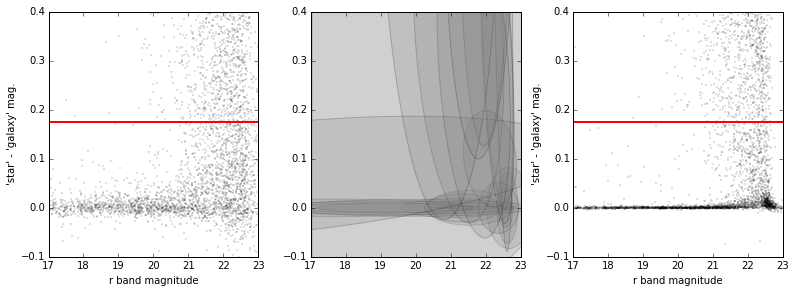

In [4]:
sdss_results_plot(Xval, samples, mus, Vs)